In [1]:
import encode_to_contact_utils as util
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
CHROMOSOME = "chr10"
START = 13600000
RESOLUTION = 8000
PATCH_SIZE = 150
STOP = START + RESOLUTION * PATCH_SIZE
PATCH_NUM = 20
MODE = "mean"
DIAG_STOP = 80
MAIN_FOLDER = ".local/experiment_results"

In [3]:
map_h1, map_hff, encode_h1, encode_hff, signal_names = util.read_data(
                                ".data/ForGrant/chr10_8k_H1.npy",
                                ".data/ForGrant/chr10_8k_HFF.npy",
                                ".data/ForGrant/bestTracksBinned.txt",
                                "../loopExtraction/data/ctcf/MA0139.1.neg.score.sorted.bedgraph",
                                "../loopExtraction/data/ctcf/MA0139.1.pos.score.sorted.bedgraph",
                                MODE,
                                CHROMOSOME,
                                START,
                                STOP,
                                RESOLUTION)


In [4]:
signal_names

array(['CTCF', 'DNAse'], dtype='<U5')

In [5]:
signal_names = np.concatenate([signal_names, ['CTCF_neg', 'CTCF_pos']])
color_dict = util.assign_unique_colors(signal_names)

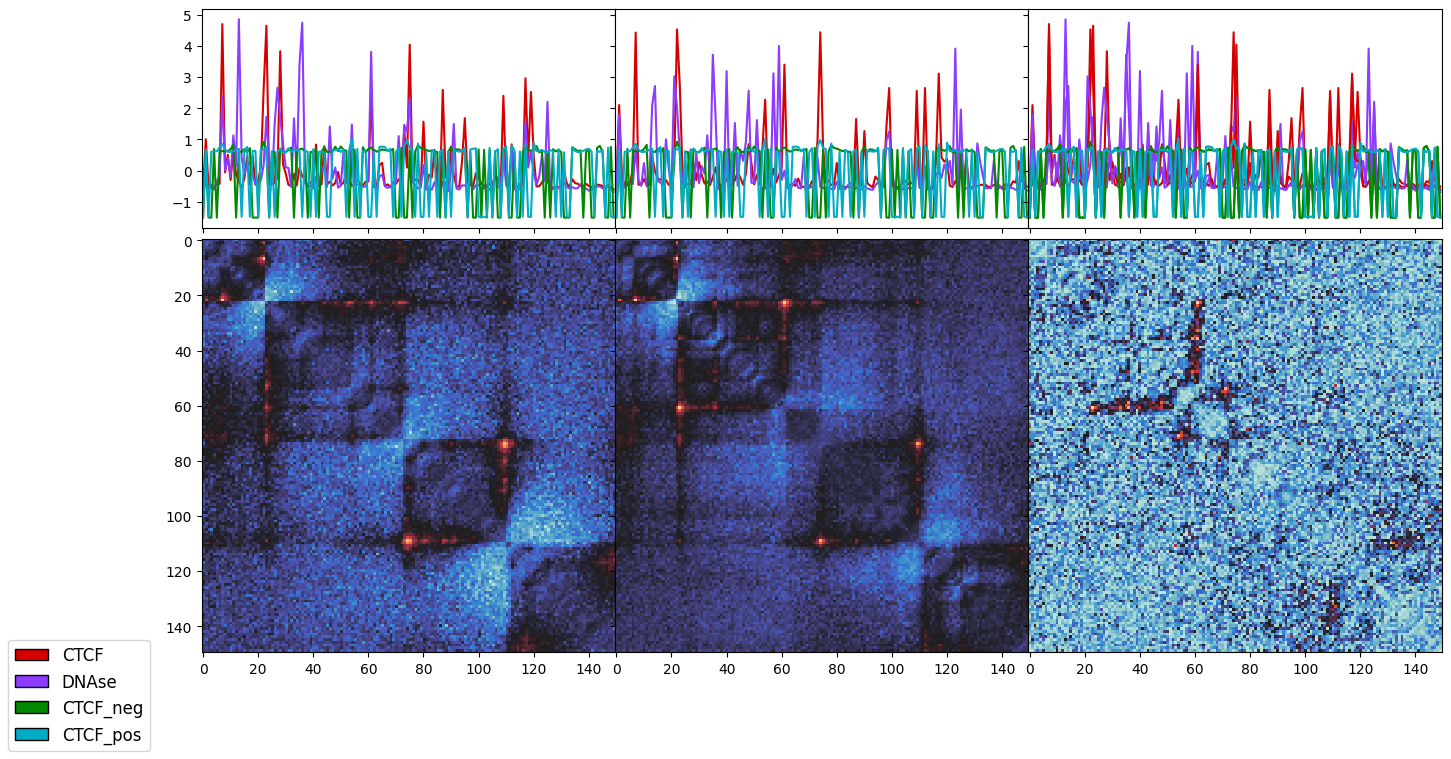

In [6]:
util.plot_map_diff(map_h1, map_hff, encode_h1, encode_hff, signal_names, signal_names, color_dict)

In [7]:
map_h1 = torch.tensor(map_h1, dtype=torch.float32)[None]
map_hff = torch.tensor(map_hff, dtype=torch.float32)[None]
encode_h1 = torch.tensor(encode_h1, dtype=torch.float32)[None]
encode_hff = torch.tensor(encode_hff, dtype=torch.float32)[None]

/tmp/ipykernel_1778103/4051511090.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map_h1 = torch.tensor(map_h1, dtype=torch.float32)[None]
/tmp/ipykernel_1778103/4051511090.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  map_hff = torch.tensor(map_hff, dtype=torch.float32)[None]


In [8]:
map_train = map_hff
map_val = map_h1
encode_train = encode_hff
encode_val = encode_h1

In [9]:
dev = torch.device('cuda')
best_loss_model, best_corr_model, arr_loss, arr_corr = util.run_training(map_train,
                                                                         map_val,
                                                                         encode_train,
                                                                         encode_val,
                                                                         dev,
                                                                         learning_rate=0.001,
                                                                         patience=100000,
                                                                         diag_start=3,
                                                                         diag_stop=DIAG_STOP,
                                                                         num_epoch=10000)

/data/src/loopextrusion_pytorch/util.py:376: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).to(dev)
/data/src/loopextrusion_pytorch/util.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mat = torch.tensor(mat)


KeyboardInterrupt: 

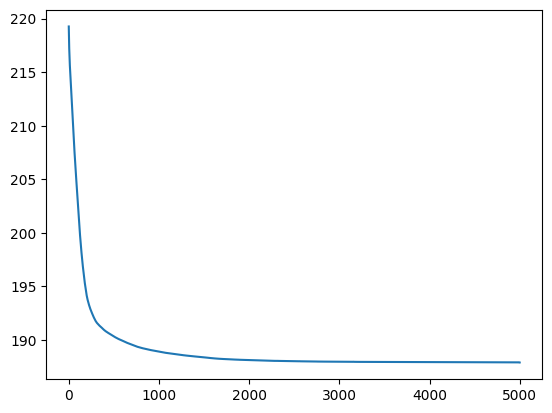

In [ ]:
plt.plot(arr_loss)

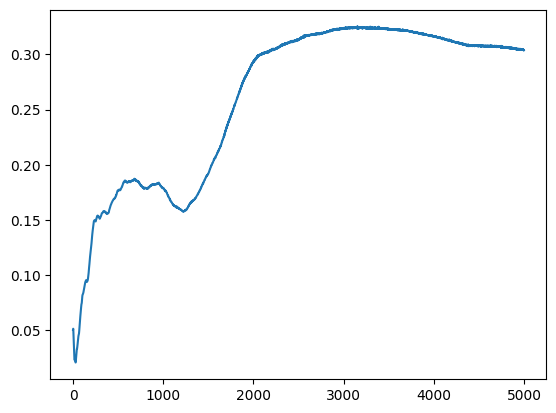

In [ ]:
plt.plot(arr_corr)

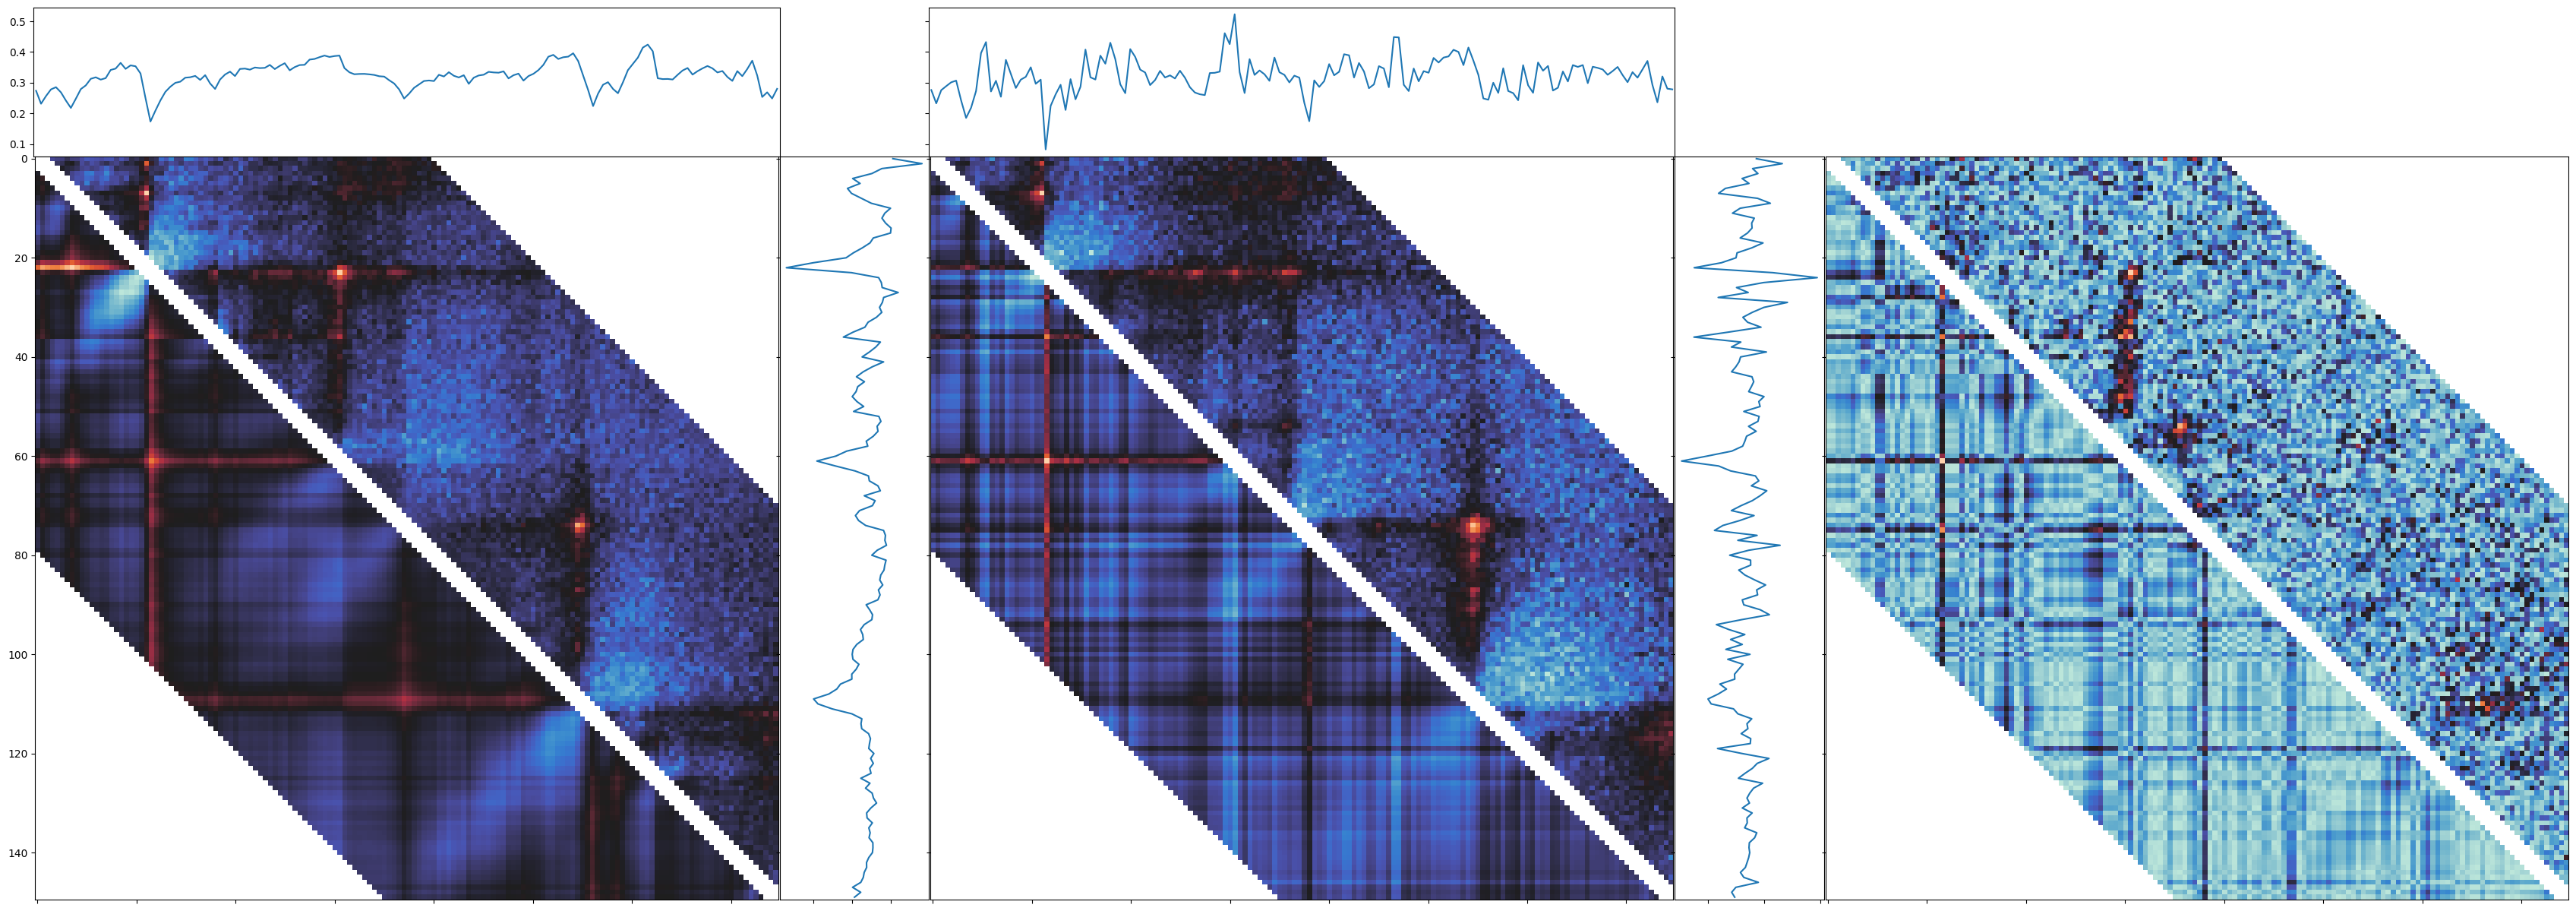

In [ ]:
util.plot_results_comp_train_val(best_loss_model, map_train[0], map_val[0], encode_train[0], encode_val[0], DIAG_STOP)

In [ ]:
signal_names

array(['CTCF', 'DNAse', 'CTCF_neg', 'CTCF_pos'], dtype='<U8')

In [ ]:
def plot_results_comp_params_sig(model, encode_train, encode_val, axes=None):
    n = encode_train.shape[1]
    if axes is None:
        _, axes = plt.subplots(nrows=n, ncols=2, figsize=(15,6),
                               sharex='col',
                               sharey='row',
                               gridspec_kw={'wspace':0,
                                           'hspace':0})
    _, p_l_train, p_r_train = util.return_model_result(model, encode_train[None])
    _, p_l_val, p_r_val = util.return_model_result(model, encode_val[None])
    for i in range(n-2):
        axes[i, 0].plot(encode_train[:,i])
        axes[i, 0].plot(encode_val[:,i])
        axes[i, 1].plot(encode_train[:,i])
        axes[i, 1].plot(encode_val[:,i])
    axes[n-2, 0].plot(encode_train[:,n-1])
    axes[n-2, 1].plot(encode_train[:,n-2])
    axes[n-1, 0].plot(p_l_train)
    axes[n-1, 0].plot(p_l_val)
    axes[n-1, 1].plot(p_r_train)
    axes[n-1, 1].plot(p_r_val)


In [ ]:
encode_h1[0][:,:2].shape

torch.Size([150, 2])

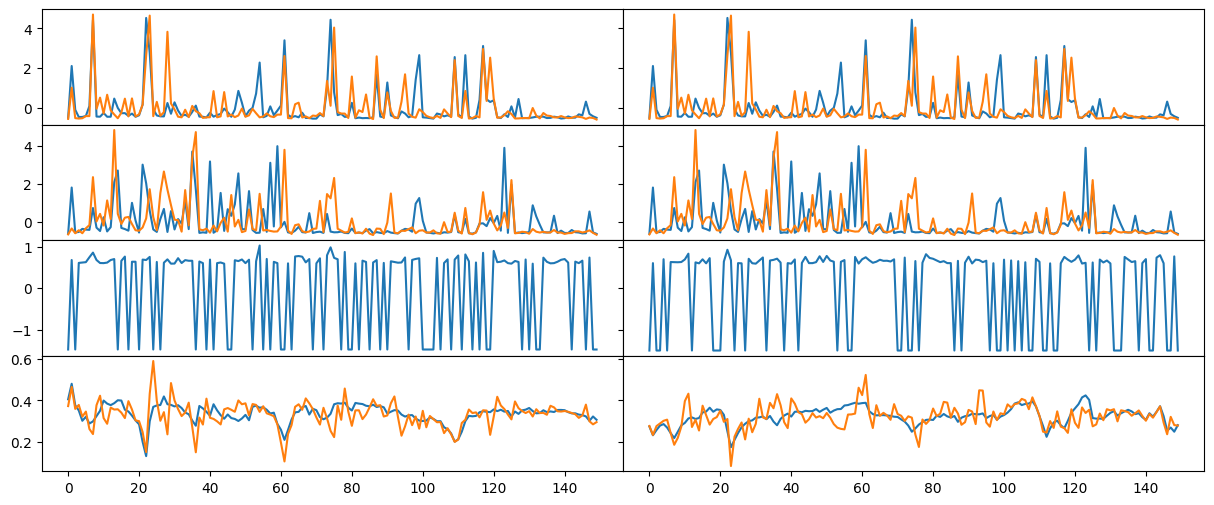

In [ ]:
plot_results_comp_params_sig(best_loss_model, encode_train[0], encode_val[0])